# Fine-tuning MegaDetector using transfer learning

## Overview
[MegaDetector](https://github.com/microsoft/CameraTraps) is a YOLOv5 object detection model trained on several hundred thousand wildlife camera trap images to detect animals, people, and vehicles. It does this extremely well, and can process thousands of images in a few hours, with high accuracy.  However, it can't classify a specific species of interest, only animals in general.  Fortunately, because it has learned to "see" camera trap imagery so well, we can leverage its knowledge to identify species we are interested in and ignore species we are not.

This tutorial builds on two tutorials provided in the YOLOv5 repo:

* https://docs.ultralytics.com/tutorials/transfer-learning-froze-layers/
* https://docs.ultralytics.com/tutorials/train-custom-datasets/

Simplistically, YOLOv5x6 (a specific version of YOLOv5) is made up of 33 layers; each layer processes the image data and then pass it on to the next layer. We can see the structure [here](https://github.com/ultralytics/yolov5/blob/master/models/hub/yolov5x6.yaml).  The first twelve layers are the backbone and are responsible for detecting objects in images. As MegaDetector already sees objects in camera trap images very well, there is no need to retrain this part of the model, so we "freeze" those layers, reducing the amount of processing required.  Layers 13 to 33 are the "head" and are responsible for classifying the detected objects. MegaDetector classifies objects as animal, person, or vehicle, but we want to be more specific, so we will retrain this part of the model.

## Set up our Kaggle environment

MegaDector uses YOLOv5x6, which needs a lot of memory for training. By using Kaggle we can get access to 16GB of GPU memory via a Telsla P100 for free!  First we need to set our Kaggle notebook to use the GPU from the settings drop down menu. This will speed up our training and inference. You will need to sign up to Kaggle to use this.

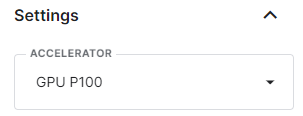

You also need to enable access to the Internet so files can be downloaded (you need to be logged in for this).

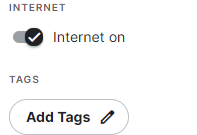

You will also need some tagged images to train on, containing species you want to detect. Let's use magpies and ravens for this example.  We also need examples of negative images, or images of things we don't want to detect.  We'll use images of quokkas, other birds, and king skinks.  YOLOv5 makes it easy to add negative images, they are just images with no corresponding label, which means we don't need to manually tag them.  

I have provided an example tagged dataset so you don't to make one to run the tutorial; it's in the "megadetector-tutorial/dataset" folder within this Kiaggle tutorial.

See https://docs.ultralytics.com/tutorials/train-custom-datasets/ to learn how to set up and tag your own images for training. 

To train and test the model, run each of the following cells in order (or press "run all" to just do it without reading).

## Install YOLOv5
We use these scripts for training

In [1]:
# Create New Conda Environment and Use Conda Channel 
!conda create -n newCondaEnvironment -c cctbx202208 python=3.9 -y
!source /opt/conda/bin/activate newCondaEnvironment && conda install -c cctbx202208 python -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 25.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/newCondaEnvironment

  added / updated specs:
    - python=3.9


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  cctbx202208
    _openmp_mutex-4.5          |            2_gnu          23 KB  cctbx202208
    bzip2-1.0.8                |       h7f98852_4         484 KB  cctbx202208
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  cctbx202208
    ld_impl_linux-64-2.36.1    |       hea4e1c9_2         667 KB  cctbx202208
    libffi-3.4.2               |       h7f98852_5          57 KB  cctbx202208
    libgcc-ng-12.1.0           |      h8d9b700_16 

In [3]:
!/opt/conda/envs/newCondaEnvironment/bin/python3 --version
!echo 'print("Hello, World!")' > test.py
!/opt/conda/envs/newCondaEnvironment/bin/python3 test.py

Python 3.9.13
Hello, World!


In [4]:
!sudo rm /opt/conda/bin/python3
!sudo ln -sf /opt/conda/envs/newCondaEnvironment/bin/python3 /opt/conda/bin/python3

In [5]:
!sudo rm /opt/conda/bin/python3.7
!sudo ln -sf /opt/conda/envs/newCondaEnvironment/bin/python3 /opt/conda/bin/python3.7

In [6]:
!sudo rm /opt/conda/bin/python
!sudo ln -s /opt/conda/envs/newCondaEnvironment/bin/python3 /opt/conda/bin/python

In [7]:
!python --version


Python 3.9.13


In [8]:
!python --version


Python 3.9.13


In [9]:
import os
!git clone https://github.com/ultralytics/yolov5
os.chdir("/kaggle/working/yolov5/")
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Total 17483 (delta 0), reused 0 (delta 0), pack-reused 17483 (from 1)
Receiving objects: 100% (17483/17483), 16.53 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (11988/11988), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 5.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 24.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 64.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 18.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 91.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 M

## Download the MegaDetector model file

MegaDetector v5 comes in two flavors, called "v5a" and "v5b", you can read more about them in the [MegaDetector v5 release notes](https://github.com/microsoft/CameraTraps/releases/tag/v5.0).  We will use MDv5a, but this tutorial will work with either flavor.
We will freeze the backbone layers of this, levereging the pretrained weights for finding objects in camera trap images, saving memory, time and reducing the number of images we need to train on:

In [10]:
!curl --keepalive -OL https://github.com/microsoft/CameraTraps/releases/download/v5.0/md_v5a.0.0.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  267M  100  267M    0     0  21.7M      0  0:00:12  0:00:12 --:--:-- 34.6M


## Prepare image data

Because we are on Kaggle, we need to copy the example image data to the working folder so we can write to the label cache files.

In [11]:
!cp -r /kaggle/input/megadetector-tutorial/dataset/ /kaggle/working/

## Train!

Using train.py from the YOLOv5 repository we downloaded earlier, let's train on the frozen backbone from MegaDetector (the first 12 layers) for ten epochs, using an image size of 1280 on the long side. Go get a coffee as this will take about an hour to run.

In [12]:
!python train.py --weights /kaggle/working/yolov5/md_v5a.0.0.pt --epochs 2 --batch-size 14 --device 0 --data /kaggle/working/dataset/dataset.yaml --imgsz 1280 --freeze 12

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
/kaggle/working/yolov5/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
train: weights=/kaggle/working/yolov5/md_v5a.0.0.pt, cfg=, data=/kaggle/working/dataset/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=14, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device

## Run our new model

Once training is finished, the training script will place several model checkpoints (.pt files) in /kaggle/working/yolov5/runs/train/exp/weights/.  We will use the best.pt model (because it's the best!), and we will use YOLOv5's detect.py function to run the model.  The MegaDetector repo provides its own inference scripts, but they don't work with our custom labels ([yet](https://github.com/microsoft/CameraTraps/issues/321)).

Let's try detecting some images with our newly minted model...

In [13]:
!python detect.py --name test --device 0 --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt --imgsz 1280 --exist-ok --conf-thres 0.1 --source /kaggle/working/dataset/test/images/

/kaggle/working/yolov5/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/working/dataset/test/images/, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-419-gcd44191c Python-3.9.13 torch-2.7.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 41

The output looks good, it seems to be detecting magpies and ravens, and no animals in images with other species! 

Let's look at some of the images.

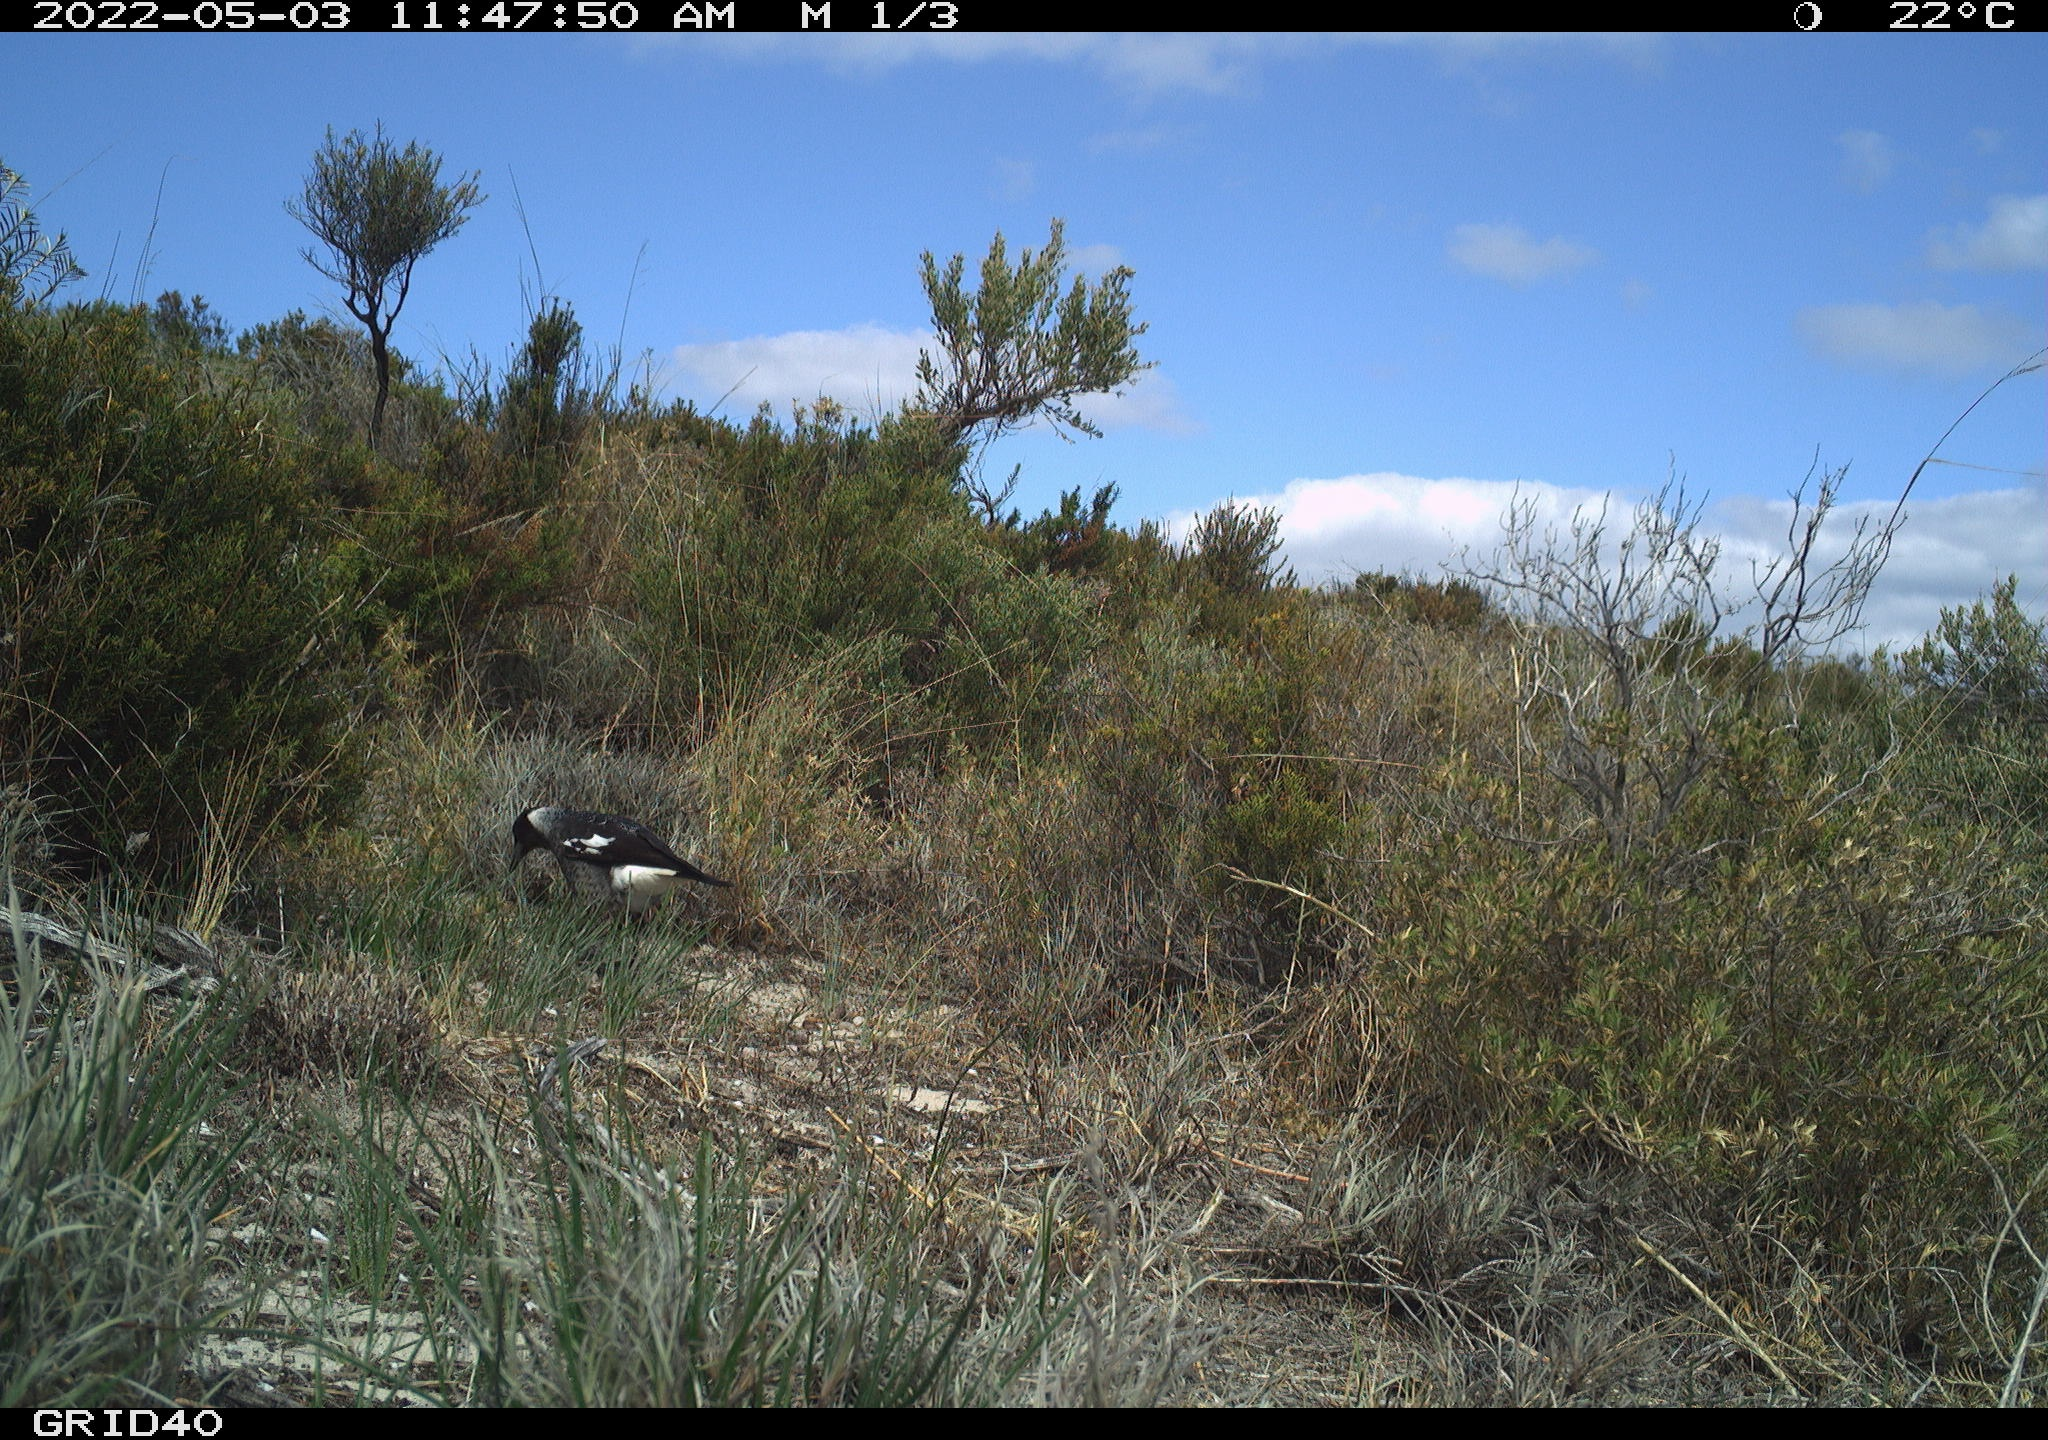

In [14]:
from IPython.display import Image
Image("runs/detect/test/magpie_0143.JPG")

Thats a magpie!

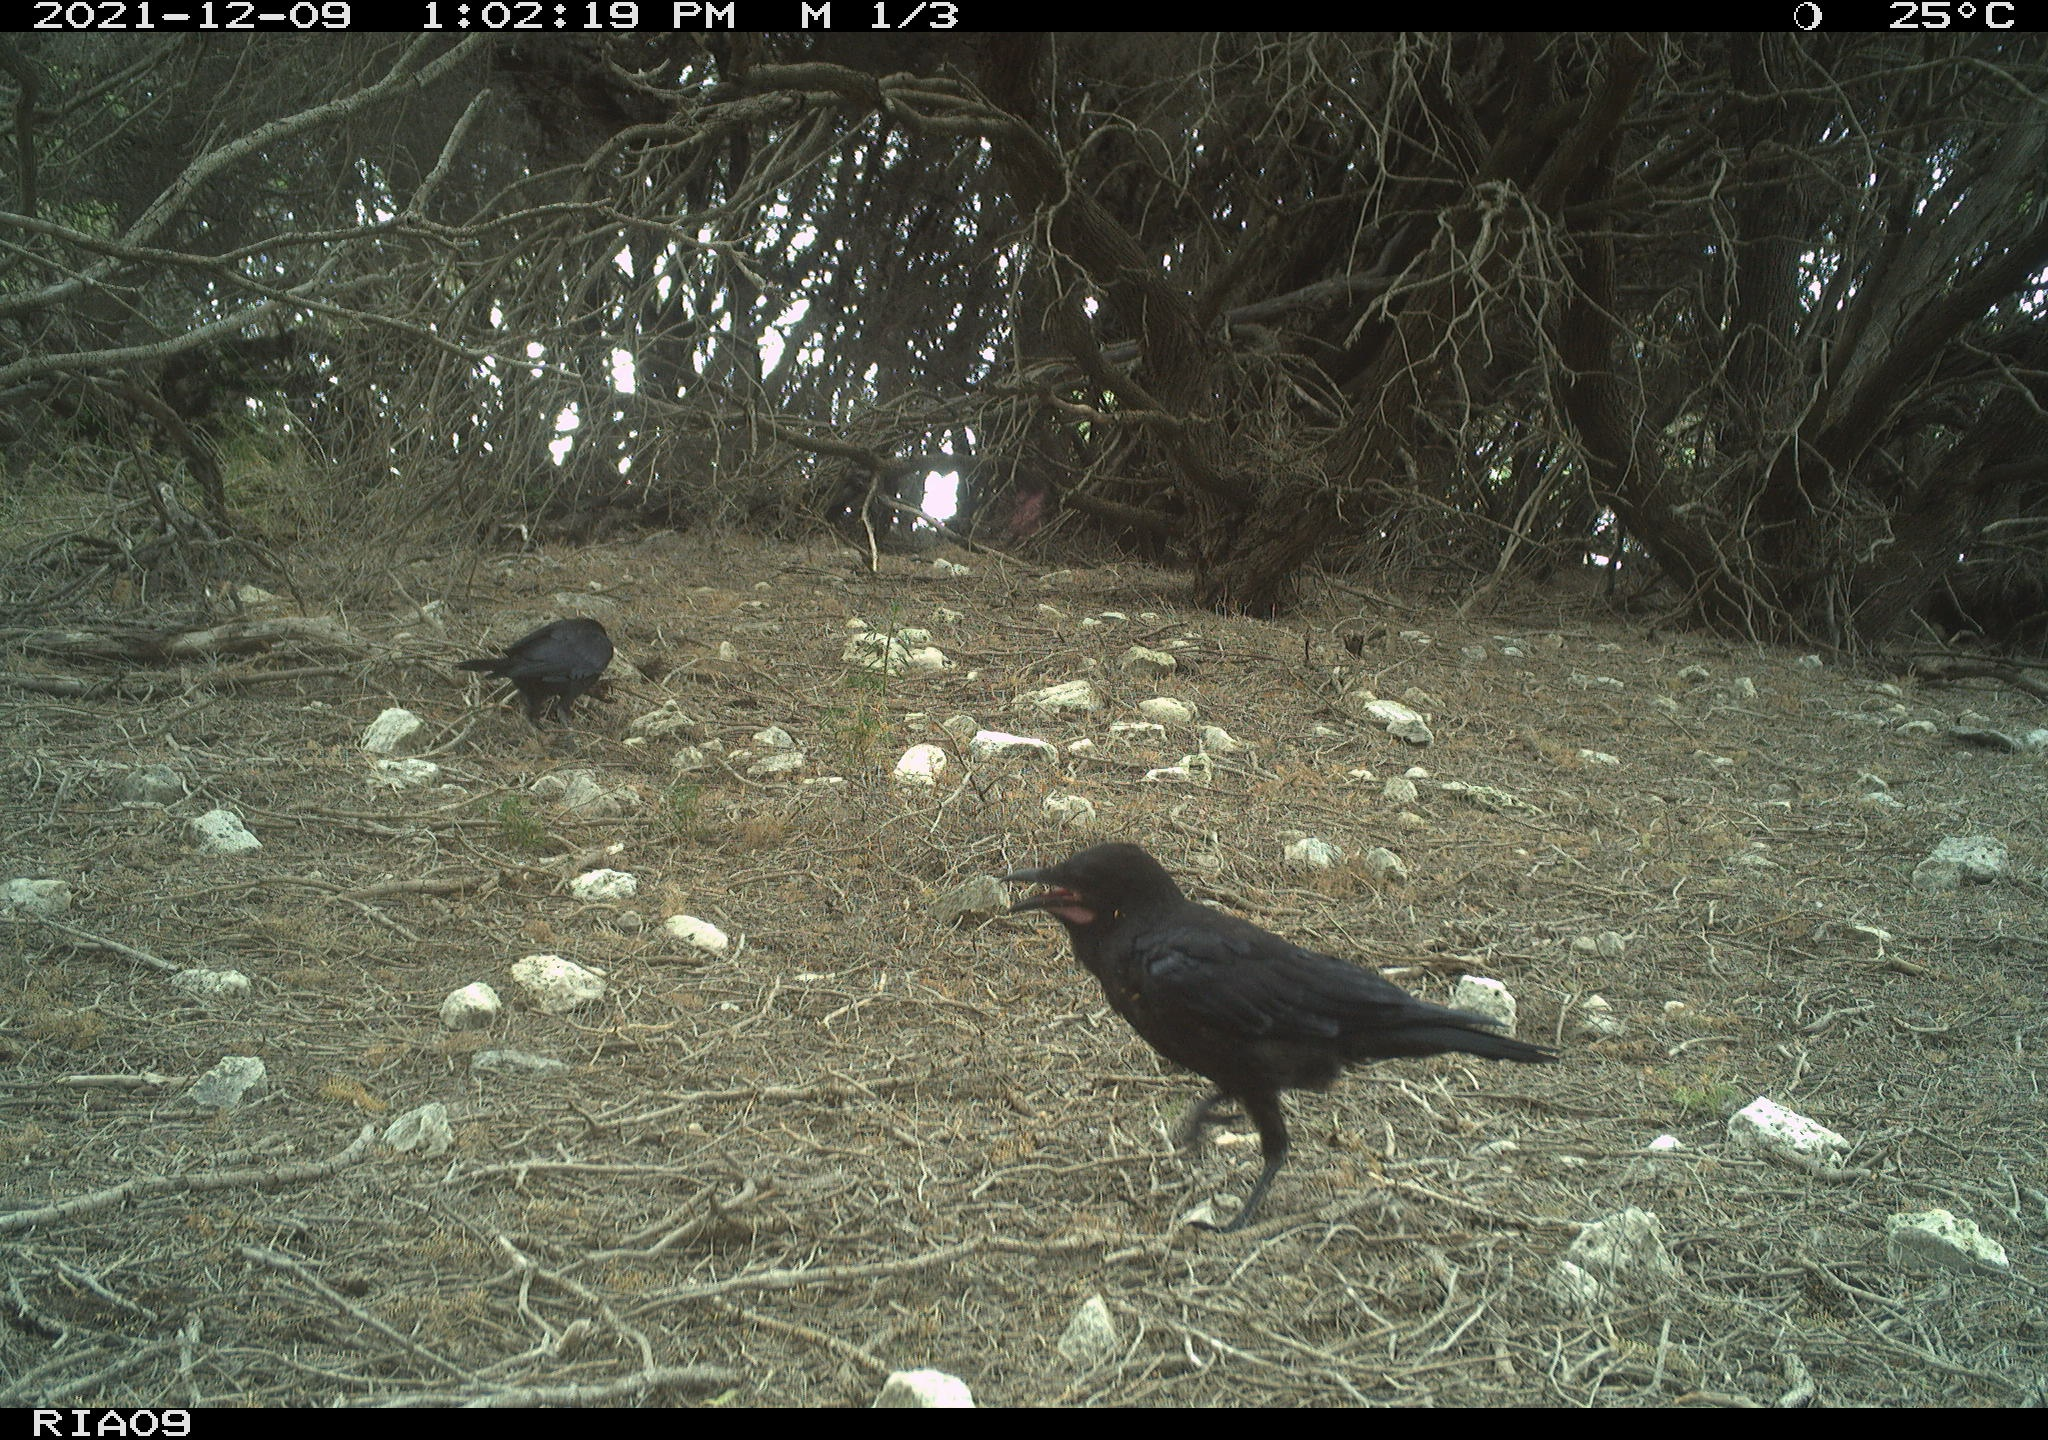

In [15]:
Image("runs/detect/test/raven_0013.JPG")

Two ravens! Fantatastic.

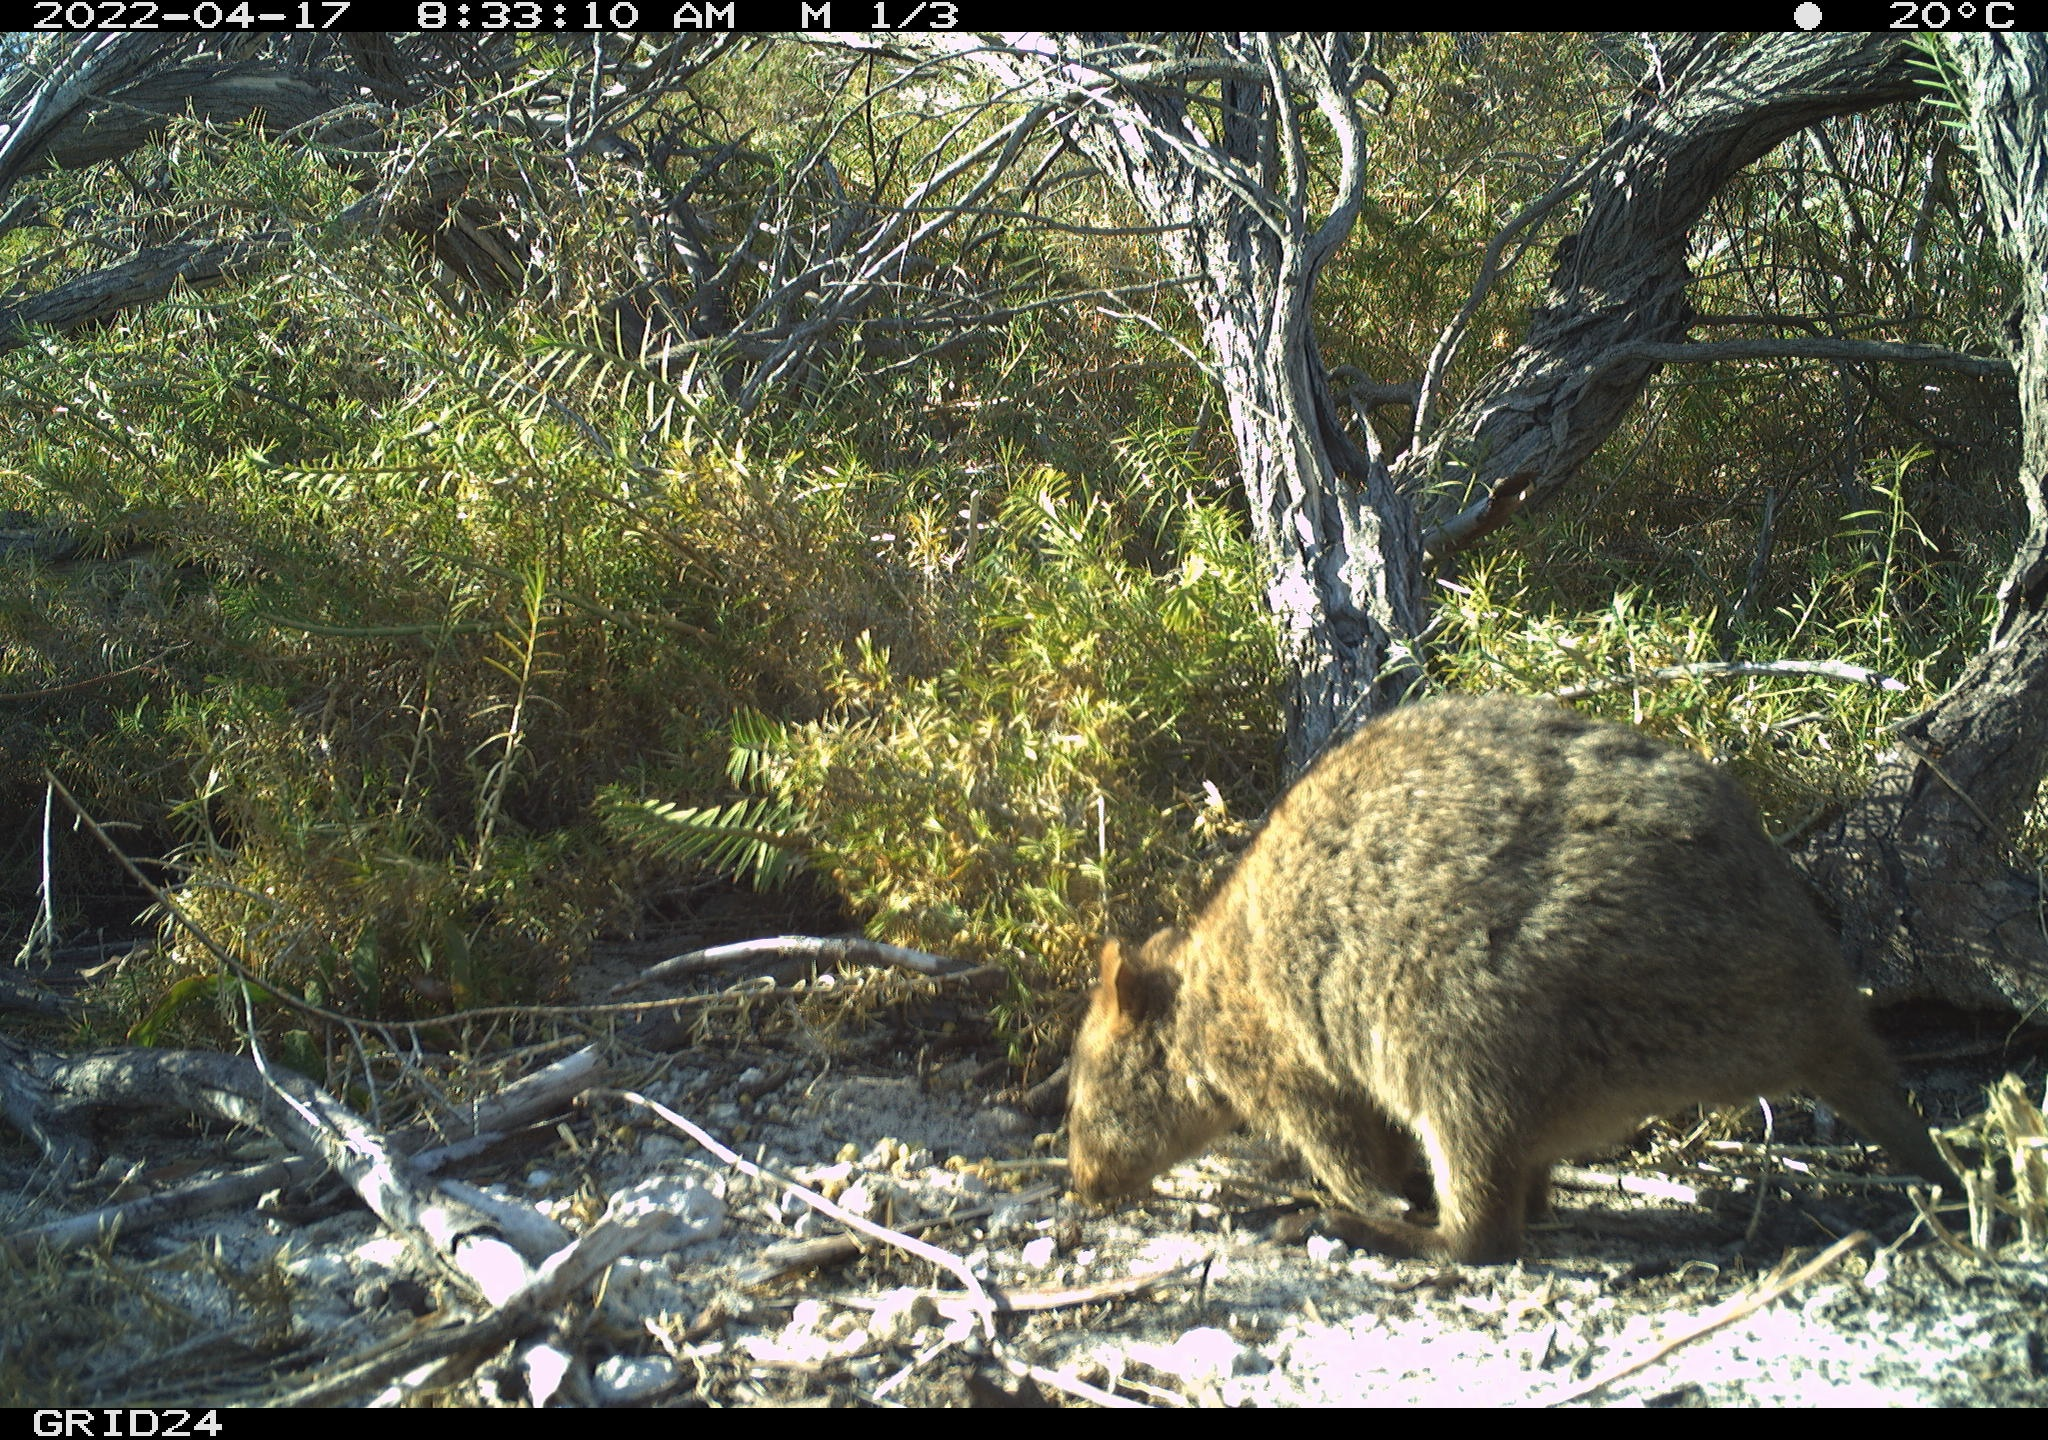

In [16]:
Image("runs/detect/test/Image_0249.JPG")

And it ignored the quokkas, which means it's working the way we want.

But there does seem to be some quokka images that were detected as magpie....

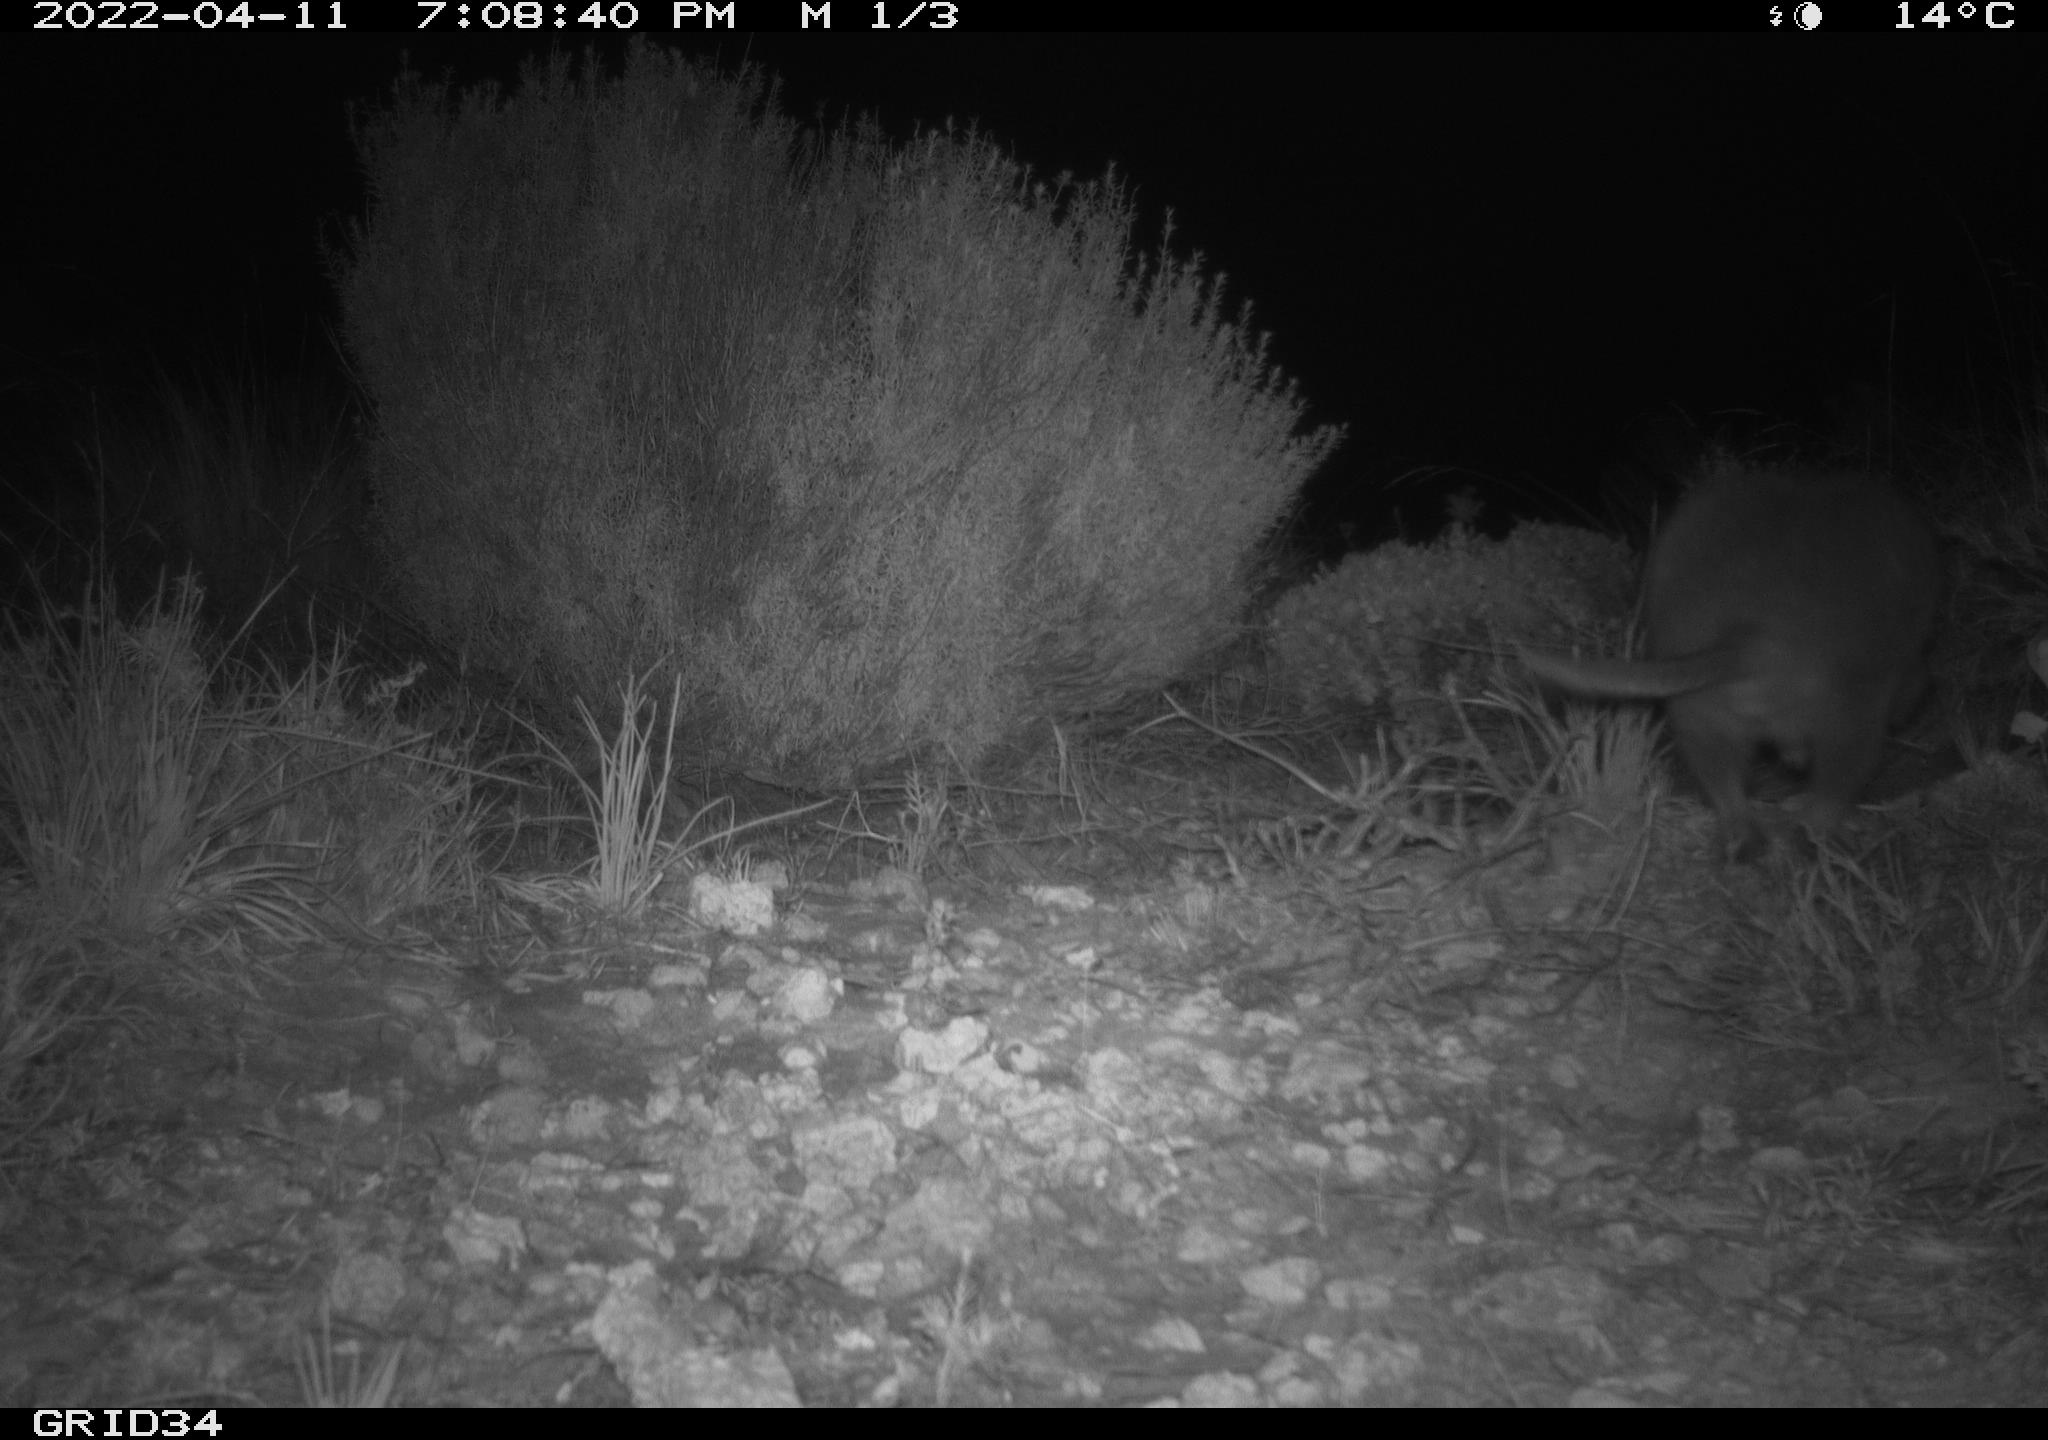

In [17]:
Image("runs/detect/test/Image_0004.JPG")

This is probably for two reasons, the main issue is that we only trained for 10 epochs.

If we look at results from training, we can see that most of the values have not leveled off yet.  Ideally we want to see these numbers flatten off at the end of training, so the graphs look like a hocky stick. 

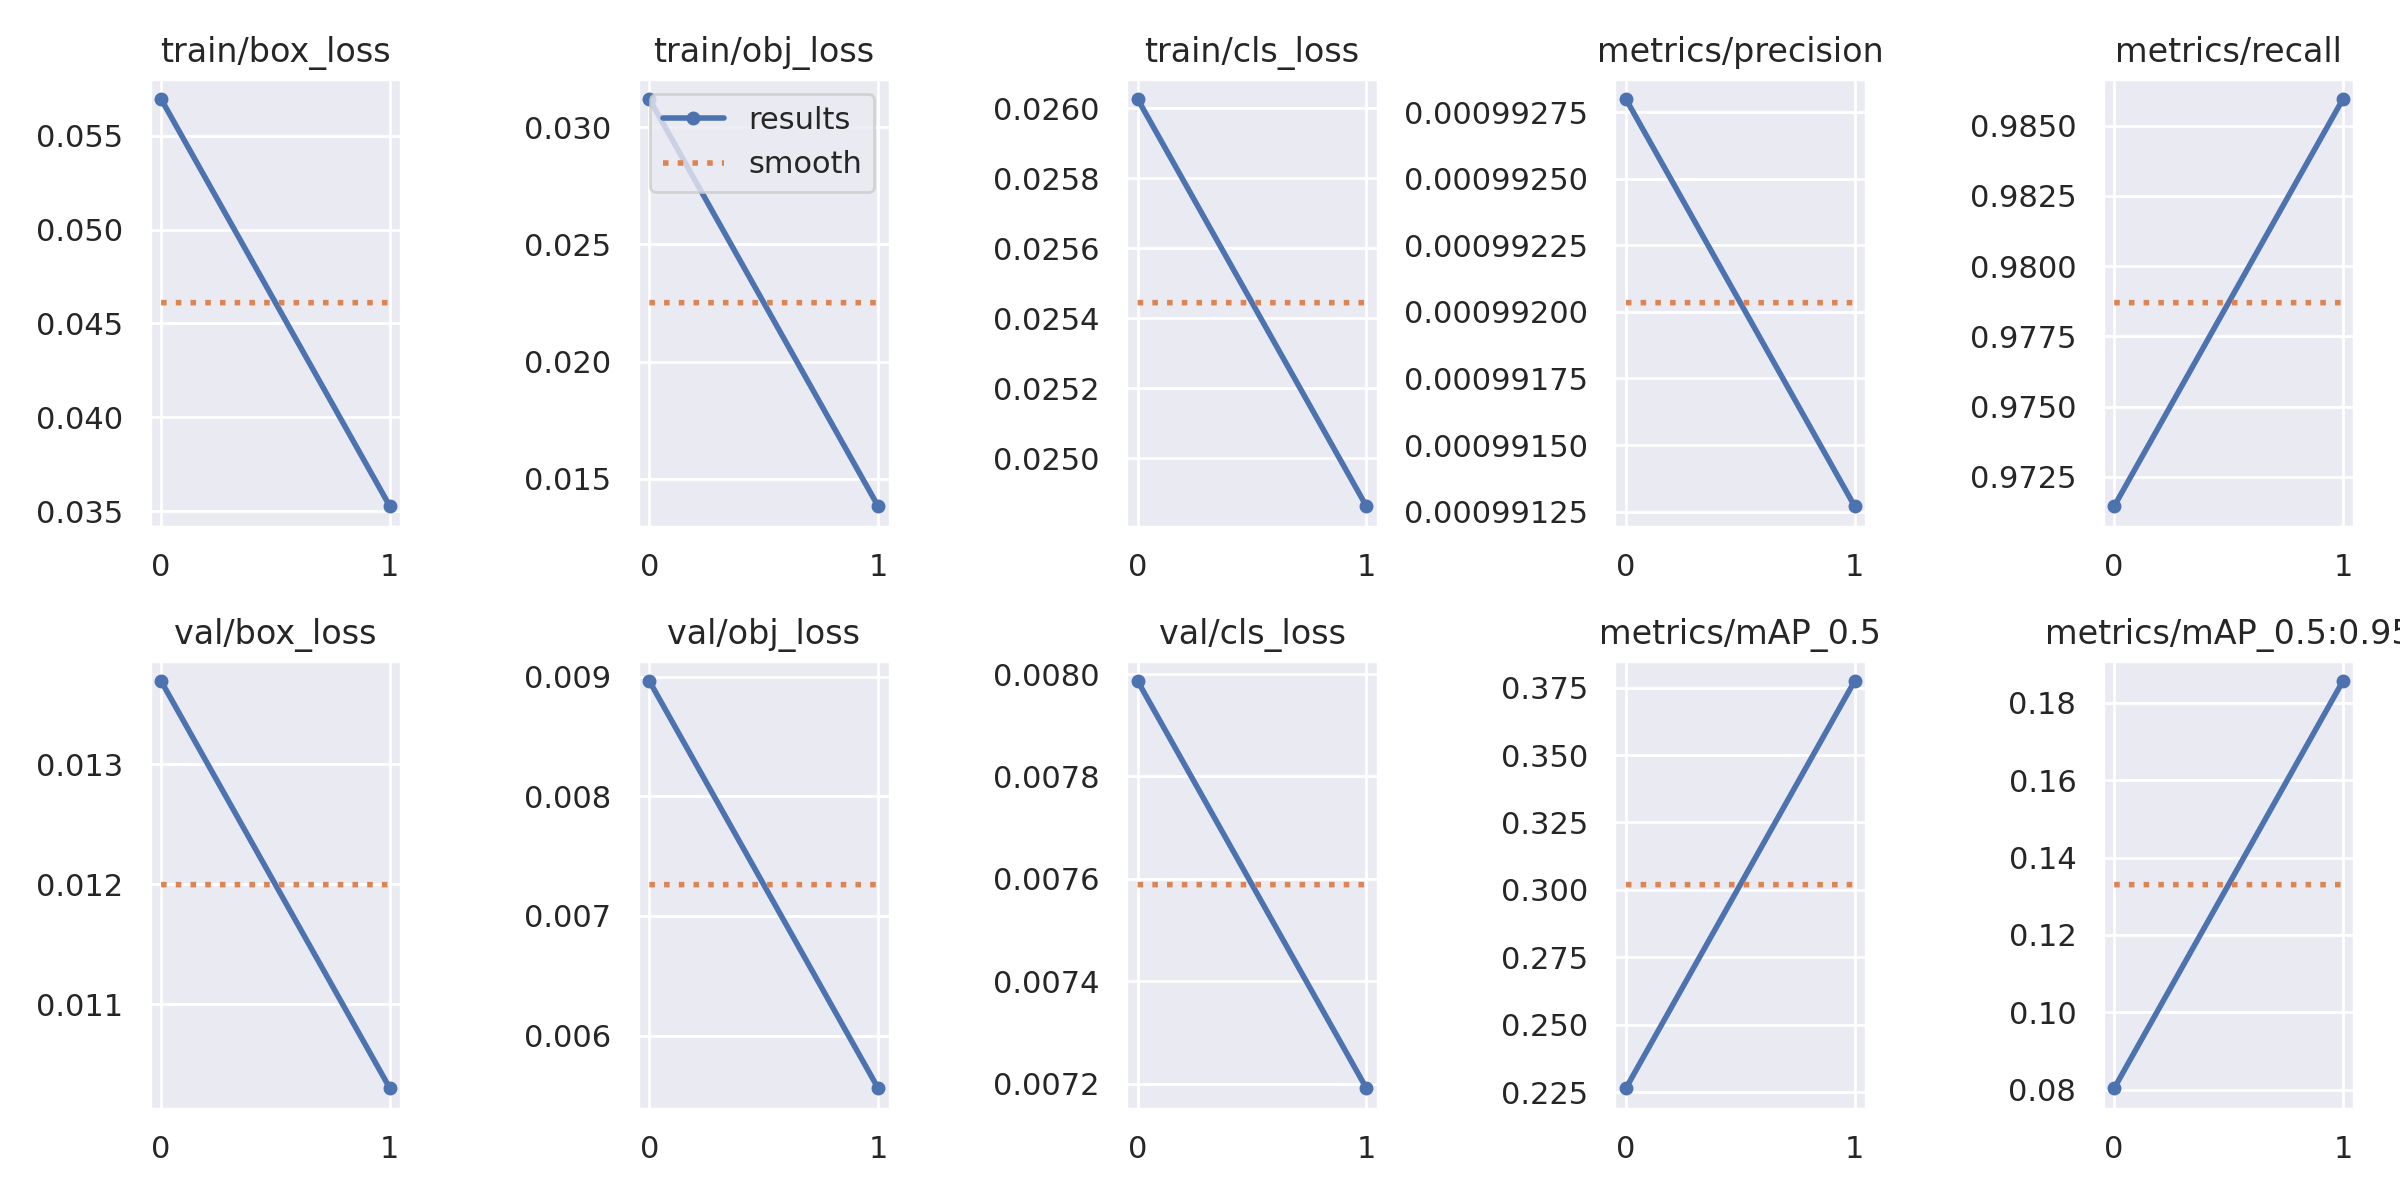

In [18]:
Image("runs/train/exp/results.png")

To do better we should probabaly train for 100 epochs or more, which will probably take a day or two. But this was just an example to get you started.  

The other issue could be that we may need more data. It's possible the model just hasn't seen enough examples to learn well enough. To solve this, we would need to add more tagged images to the data.

I hope you found this helpful.  If you want to understand the training process better jump over to https://docs.ultralytics.com/tutorials/train-custom-datasets/